## Problem Statement

A cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth from the neutral mutations. 
Considering this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations based on evidence from text-based clinical literature.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import time
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")

#### Loading the data:

In [2]:
data=pd.read_csv('training_variants')
print('Total gene variations:',data.shape[0])
print('Total features:',data.shape[1])
print('Features:',data.columns.values)
data.head()

Total gene variations: 3321
Total features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
text_data=pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Total gene variations:',text_data.shape[0])
print('Total features:',text_data.shape[1])
print('Features:',text_data.columns.values)
text_data.head()

Total gene variations: 3321
Total features: 2
Features: ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Preprocessing of Text

In [4]:
#stop words
stop_words=set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string

In [5]:
start_time = time.perf_counter()
for index, row in text_data.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 56.37125920003746 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text_data,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT']=result['Gene'] +' '+ result['Variation']

In [9]:
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


In [167]:
path='unchanged_data.csv'
result.to_csv(path,index=False)
print(f"\nCleaned data successfully exported to {path}")


Cleaned data successfully exported to unchanged_data.csv


In [169]:
result['Gene_Variation'] = result['Gene'] + '_' + result['Variation']

In [174]:
result

,ID,Class,TEXT,Gene_Variation
0,0,1,cyclin dependent kinases cdks regulate variety...,FAM58A_Truncating Mutations
1,1,2,abstract background non small cell lung cancer...,CBL_W802*
2,2,2,abstract background non small cell lung cancer...,CBL_Q249E
3,3,3,recent evidence demonstrated acquired uniparen...,CBL_N454D
4,4,4,oncogenic mutations monomeric casitas b lineag...,CBL_L399V
...,...,...,...,...
3316,3316,4,introduction myelodysplastic syndromes mds het...,RUNX1_D171N
3317,3317,1,introduction myelodysplastic syndromes mds het...,RUNX1_A122*
3318,3318,1,runt related transcription factor 1 gene runx1...,RUNX1_Fusions
3319,3319,4,runx1 aml1 gene frequent target chromosomal tr...,RUNX1_R80C


In [175]:
path='changed_data.csv'
result.to_csv(path,index=False)
print(f"\nCleaned data successfully exported to {path}")


Cleaned data successfully exported to changed_data.csv


### Train, CV and Test Datasets

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### Distribution of yi's in all splits:

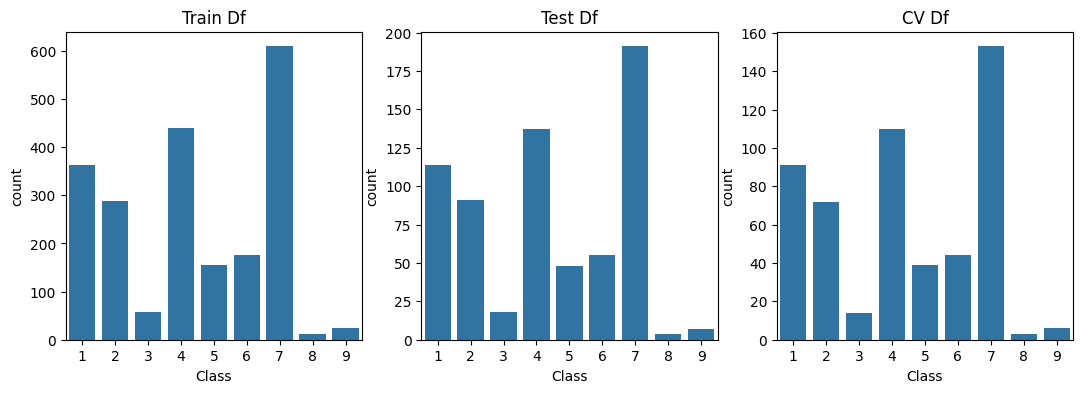

In [12]:
fig, axes = plt.subplots(1,3,figsize=(13, 4))

sns.barplot(train_df['Class'].value_counts(),ax=axes[0])
sns.barplot(test_df['Class'].value_counts(),ax=axes[1])
sns.barplot(cv_df['Class'].value_counts(),ax=axes[2])
axes[0].set_title('Train Df')
axes[1].set_title('Test Df')
axes[2].set_title('CV Df')
plt.show()

Distribution of Train, Test and CV data are roughly same and each of imbalanced data.

### Random Model

In [13]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T) #recall
    B =(C/C.sum(axis=0)) #precision
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [14]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
np.random.seed(42)
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
test_predicted_y=np.zeros((test_data_len,9))
np.random.seed(42)
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y))
print("Log loss on Test Validation Data using Random Model",log_loss(y_test,test_predicted_y))

Log loss on Cross Validation Data using Random Model 2.47811464793097
Log loss on Test Validation Data using Random Model 2.5482728226215565


-------------------- Confusion matrix --------------------


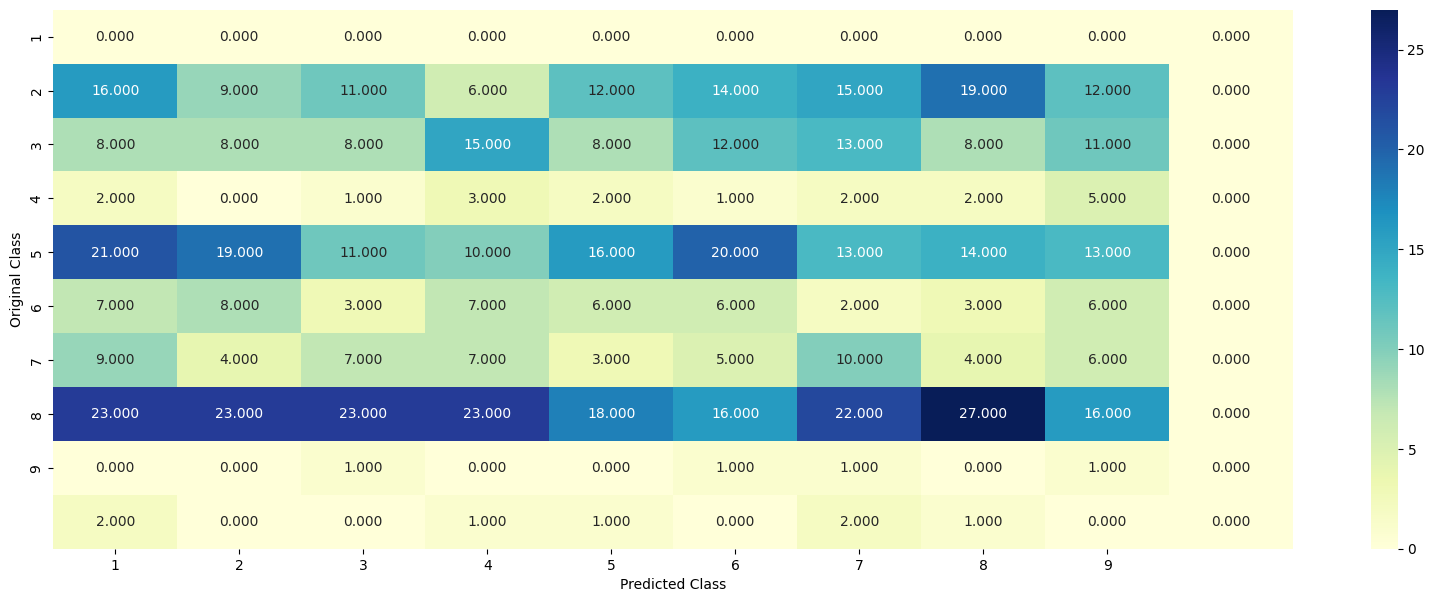

-------------------- Precision matrix (Columm Sum=1) --------------------


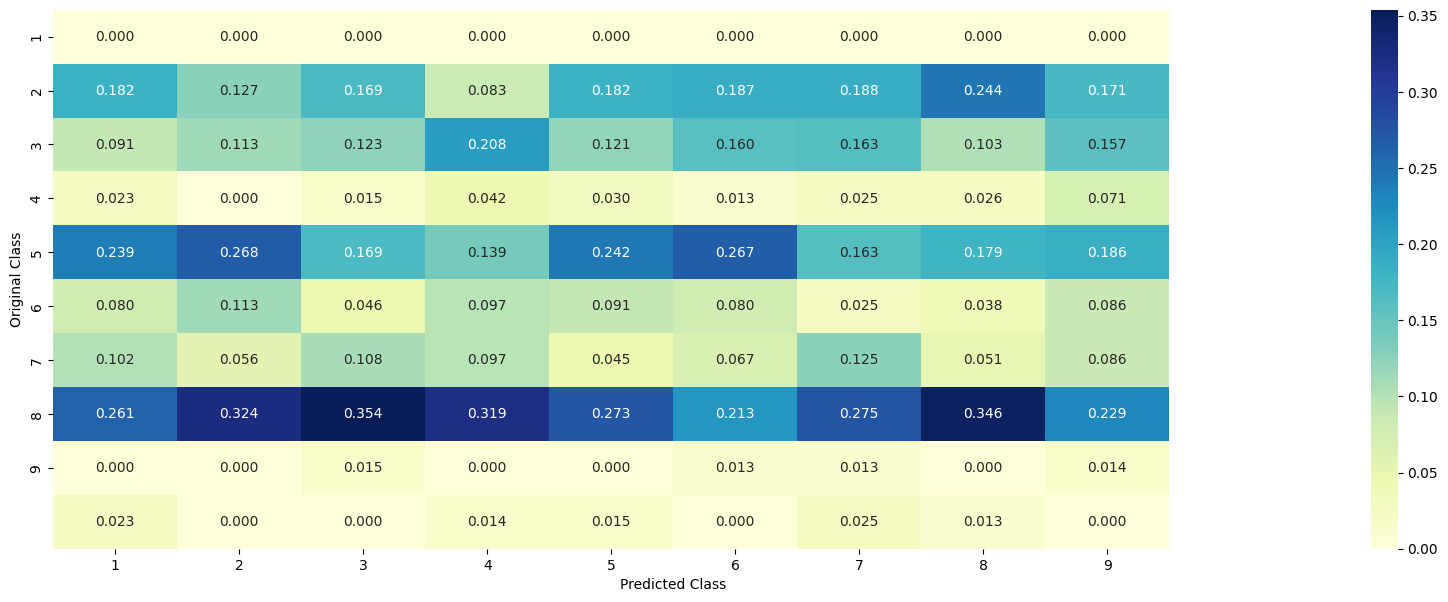

-------------------- Recall matrix (Row sum=1) --------------------


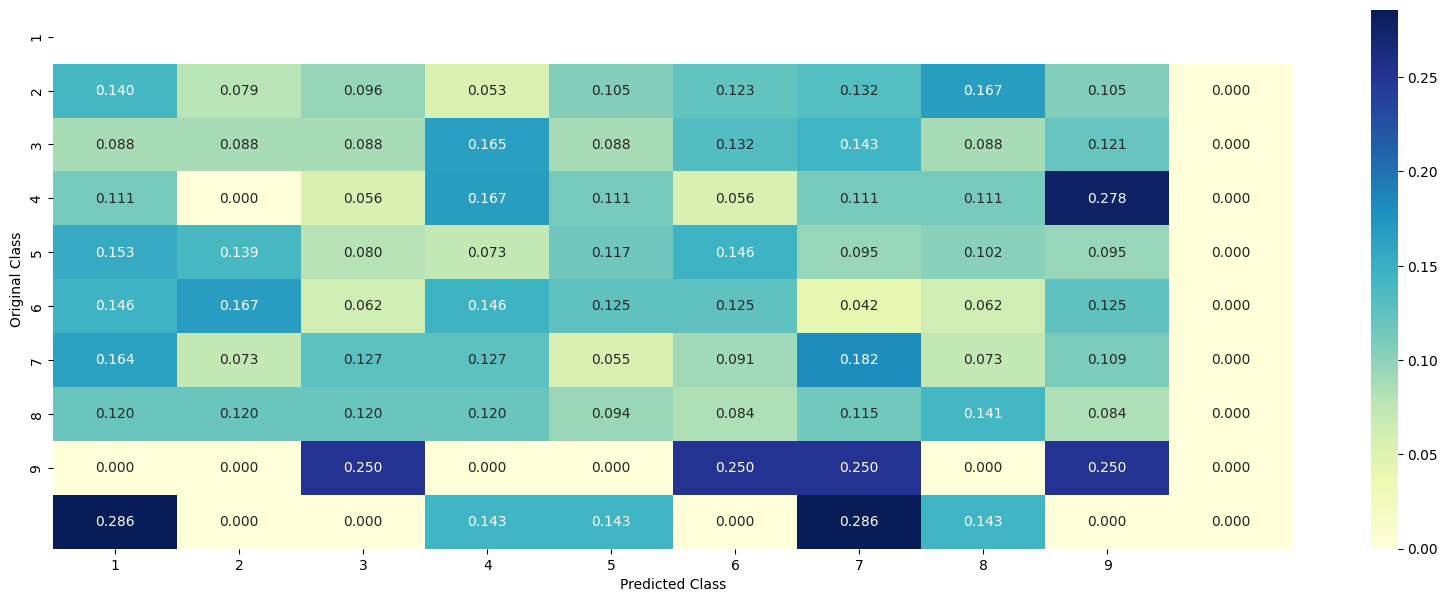

In [15]:
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test,predicted_y)

### Univariate Analysis of Gene Feature

In [16]:
print('Unique Gene counts:',train_df['Gene'].value_counts().shape[0])
train_df['Gene'].value_counts().head(10)

Unique Gene counts: 229


Gene
BRCA1     160
TP53      102
EGFR       87
PTEN       82
BRCA2      78
KIT        65
BRAF       57
ERBB2      53
ALK        44
PIK3CA     43
Name: count, dtype: int64

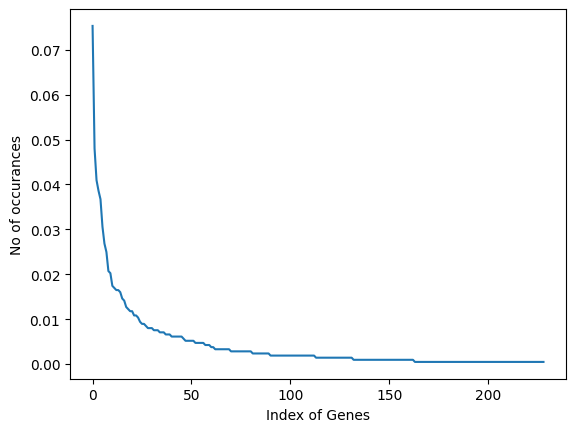

In [17]:
h=sum(train_df['Gene'].value_counts().values)
s=(train_df['Gene'].value_counts().values)/h

plt.plot(s)
plt.xlabel('Index of Genes')
plt.ylabel('No of occurances')
plt.show()

In [18]:
train_df['Gene'].value_counts().values

array([160, 102,  87,  82,  78,  65,  57,  53,  44,  43,  37,  36,  35,
        35,  34,  31,  30,  27,  26,  25,  25,  23,  23,  22,  20,  19,
        19,  18,  17,  17,  17,  16,  16,  16,  15,  15,  15,  14,  14,
        14,  13,  13,  13,  13,  13,  13,  12,  11,  11,  11,  11,  11,
        10,  10,  10,  10,  10,   9,   9,   9,   8,   8,   7,   7,   7,
         7,   7,   7,   7,   7,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   5,   5,   5,   5,   5,   5,   5,   5,   5,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [19]:
#Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [20]:
###---response coding
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
train_gene_feature_responseCoding = (train_gene_feature_responseCoding.T / train_gene_feature_responseCoding.sum(axis=1)).T

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
test_gene_feature_responseCoding = (test_gene_feature_responseCoding.T / test_gene_feature_responseCoding.sum(axis=1)).T

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))
cv_gene_feature_responseCoding = (cv_gene_feature_responseCoding.T / cv_gene_feature_responseCoding.sum(axis=1)).T

In [21]:
# TfidfVectorizer of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

In [22]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'arid2', 'asxl2', 'atm', 'atr',
       'atrx', 'aurka', 'aurkb', 'b2m', 'bap1', 'bcl10', 'bcl2',
       'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brip1', 'btk',
       'card11', 'carm1', 'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3',
       'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a',
       'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2', 'cic', 'crebbp',
       'ctcf', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3b', 'dusp4', 'egfr',
       'eif1ax', 'elf3', 'ep300', 'epas1', 'erbb2', 'erbb3', 'erbb4',
       'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv1', 'etv6',
       'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fancc', 'fat1', 'fbxw7',
       'fgf19', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt3',
       'foxa1', 'foxl2', 'foxp1', 'fubp1', 'gli1', 'gna11', 'gnas',
       'h3f3a', 'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1', 'idh2',
       'igf1r', 'il7r', 'ja

In [23]:
##to check how good is the feature gene for predicting yi with one hot encoding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


For values of alpha =  1e-05 The log loss is: 1.204861566020155
For values of alpha =  0.0001 The log loss is: 1.2189285702625936
For values of alpha =  0.001 The log loss is: 1.2289596953860185
For values of alpha =  0.01 The log loss is: 1.2741255820713426
For values of alpha =  0.1 The log loss is: 1.351361295269161
For values of alpha =  1 The log loss is: 1.3604725818629682
For values of best alpha =  1e-05 The train log loss is: 1.0011621305256755
For values of best alpha =  1e-05 The cross validation log loss is: 1.204861566020155
For values of best alpha =  1e-05 The test log loss is: 1.1605197889223264


In [24]:
##to check how good is the feature gene for predicting yi with response coding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.3022634574949141
For values of alpha =  0.0001 The log loss is: 1.3061629974692937
For values of alpha =  0.001 The log loss is: 1.344515752077721
For values of alpha =  0.01 The log loss is: 1.3723648921148581
For values of alpha =  0.1 The log loss is: 1.3807319503050297
For values of alpha =  1 The log loss is: 1.3963638020527978
For values of best alpha =  1e-05 The train log loss is: 1.183554362911392
For values of best alpha =  1e-05 The cross validation log loss is: 1.3022634574949141
For values of best alpha =  1e-05 The test log loss is: 1.2482813793433292


#### with clear comparasion of log loss among cross and test data are close to eachother which implies Gene feature is stable.

### Univariate Analysis of Variation Feature

In [25]:
print('Unique Variation counts:',train_df['Variation'].value_counts().shape[0])
train_df['Variation'].value_counts().head(10)

Unique Variation counts: 1923


Variation
Truncating Mutations    65
Amplification           46
Deletion                42
Fusions                 23
Overexpression           4
Q61L                     3
G12V                     3
T58I                     3
EWSR1-ETV1 Fusion        2
G13D                     2
Name: count, dtype: int64

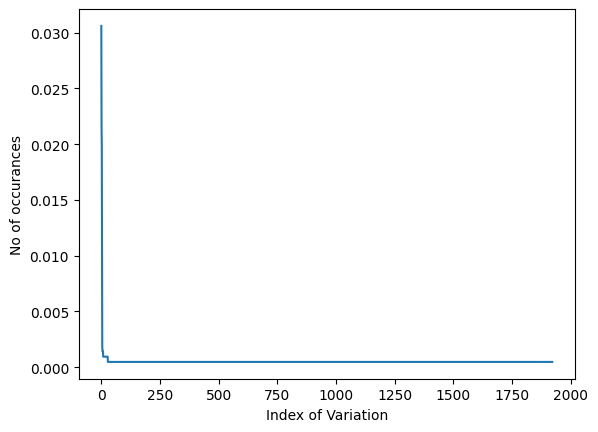

In [26]:
h=sum(train_df['Variation'].value_counts().values)
s=(train_df['Variation'].value_counts().values)/h

plt.plot(s)
plt.xlabel('Index of Variation')
plt.ylabel('No of occurances')
plt.show()

In [27]:
###---response coding
alpha=1
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
train_variation_feature_responseCoding=(train_variation_feature_responseCoding.T/train_variation_feature_responseCoding.sum(axis=1)).T
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
test_variation_feature_responseCoding = (test_variation_feature_responseCoding.T/test_variation_feature_responseCoding.sum(axis=1)).T
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))
cv_variation_feature_responseCoding=(cv_variation_feature_responseCoding.T/cv_variation_feature_responseCoding.sum(axis=1)).T

In [28]:
# TfidfVectorizer of Variation feature.
variation_vectorizer = TfidfVectorizer()
#train variation feature
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
#test variation feature
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
#cv variation feature
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding,axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding,axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding,axis=0)

In [29]:
variation_vectorizer.get_feature_names_out()

array(['13', '19', '20', ..., 'y98n', 'yap1', 'zc3h7b'], dtype=object)

In [30]:
##to check how good is the feature variation for predicting yi with one hot encoding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.7195837909959106
For values of alpha =  0.0001 The log loss is: 1.7044489224443085
For values of alpha =  0.001 The log loss is: 1.7006353561358112
For values of alpha =  0.01 The log loss is: 1.712958391156447
For values of alpha =  0.1 The log loss is: 1.7283532309188125
For values of alpha =  1 The log loss is: 1.7251026422680507
For values of best alpha =  0.001 The train log loss is: 0.46120015494218963
For values of best alpha =  0.001 The cross validation log loss is: 1.7006353561358112
For values of best alpha =  0.001 The test log loss is: 1.6819315156061625


In [31]:
##to check how good is the feature gene for predicting yi with response coding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 2.1816602231057383
For values of alpha =  0.0001 The log loss is: 1.91670181487293
For values of alpha =  0.001 The log loss is: 1.8968952076537808
For values of alpha =  0.01 The log loss is: 1.8984193093004424
For values of alpha =  0.1 The log loss is: 1.8985432080974005
For values of alpha =  1 The log loss is: 1.8984513655190776
For values of best alpha =  0.001 The train log loss is: 0.7753531893348943
For values of best alpha =  0.001 The cross validation log loss is: 1.8968952076537808
For values of best alpha =  0.001 The test log loss is: 1.832484244895534


#### with clear comparasion of log loss among cross and test data are almost close to eachother which implies Variation feature is stable.

### Univariate Analysis of TEXT Feature

In [32]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [33]:
# building a TfidVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52559


In [34]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [35]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [36]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [37]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [38]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [39]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.float64(0.014301873893182899): 320, np.float64(0.03999680320678075): 233, np.float64(0.021136074779815158): 220, np.float64(0.06979901369694903): 204, np.float64(0.3117690405194421): 156, np.float64(0.025911120598427352): 137, np.float64(0.22890022617717828): 130, np.float64(0.062632906282527): 124, np.float64(0.037688686667663646): 116, np.float64(0.019257406024787066): 111, np.float64(0.049385646097148544): 110, np.float64(0.0630041016573083): 102, np.float64(0.05664286862154974): 102, np.float64(0.07461381797041731): 100, np.float64(0.010319710246781287): 100, np.float64(0.04405095053548222): 96, np.float64(0.037353864350881866): 96, np.float64(0.11533600781441843): 95, np.float64(0.020470368261630026): 95, np.float64(0.03794724044663902): 93, np.float64(0.0215935294078824): 89, np.float64(0.019721893501256523): 84, np.float64(0.017917864317531507): 84, np.float64(0.012160860113183906): 83, np.float64(0.023156992979381404): 80, np.float64(0.04453204387237087): 78, np.flo

In [40]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


For values of alpha =  1e-05 The log loss is: 1.2388209205041953
For values of alpha =  0.0001 The log loss is: 1.0581233885401131
For values of alpha =  0.001 The log loss is: 1.077507029438757
For values of alpha =  0.01 The log loss is: 1.210088019078402
For values of alpha =  0.1 The log loss is: 1.439848976690601
For values of alpha =  1 The log loss is: 1.625911848840017
For values of best alpha =  0.0001 The train log loss is: 0.6083590827642638
For values of best alpha =  0.0001 The cross validation log loss is: 1.0581233885401131
For values of best alpha =  0.0001 The test log loss is: 1.101029520542333


#### with clear comparasion of log loss among cross and test data are close to eachother which implies Text feature is stable.

## Machine Learning Models

In [41]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [42]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [43]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking three types of features

In [44]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [45]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54734)
(number of data points * number of features) in test data =  (665, 54734)
(number of data points * number of features) in cross validation data = (532, 54734)


In [46]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [47]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


### Base Line Model

#### 1. Naive Bayes

In [48]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
    
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


for alpha = 1e-05
Log Loss : 1.2538903716516545
for alpha = 0.0001
Log Loss : 1.25825832200105
for alpha = 0.001
Log Loss : 1.260428649212607
for alpha = 0.1
Log Loss : 1.2567451563637966
for alpha = 1
Log Loss : 1.32039303752389
for alpha = 10
Log Loss : 1.403466806191009
for alpha = 100
Log Loss : 1.3351501919857718
for alpha = 1000
Log Loss : 1.2815721742978803
For values of best alpha =  1e-05 The train log loss is: 0.7920212855580782
For values of best alpha =  1e-05 The cross validation log loss is: 1.2538903716516545
For values of best alpha =  1e-05 The test log loss is: 1.2713787750860213


Log Loss : 1.2538903716516545
Number of missclassified point : 0.3815789473684211
-------------------- Confusion matrix --------------------


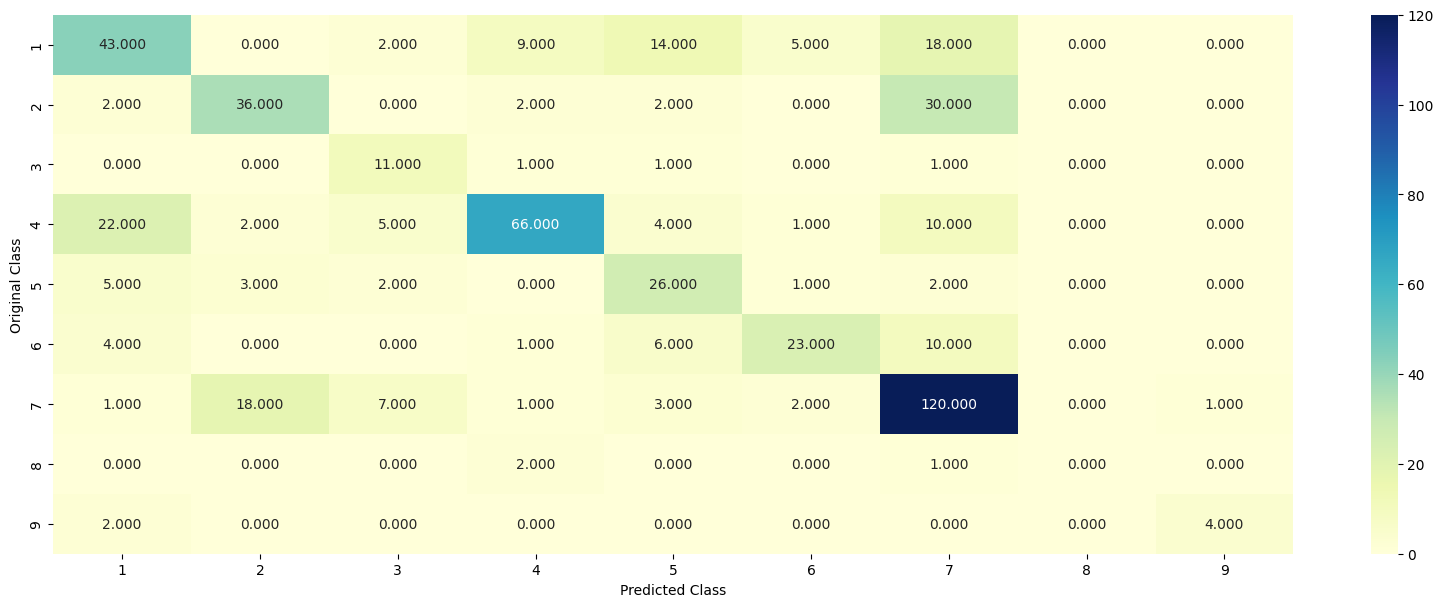

-------------------- Precision matrix (Columm Sum=1) --------------------


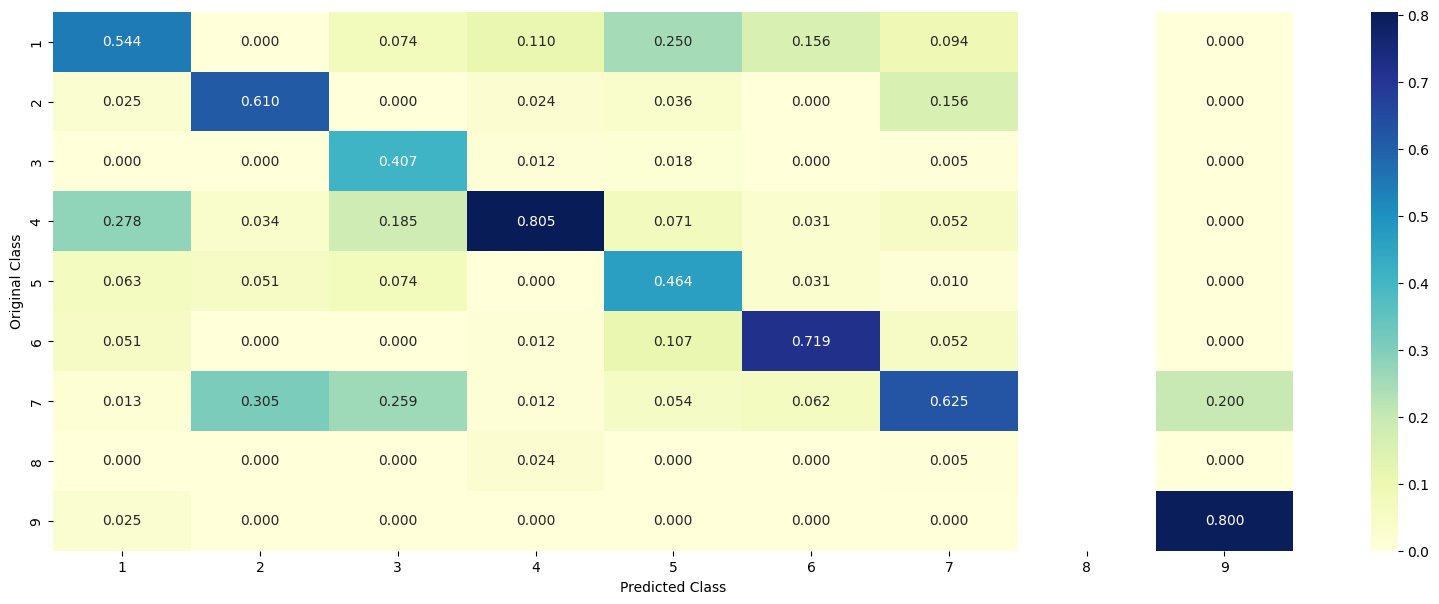

-------------------- Recall matrix (Row sum=1) --------------------


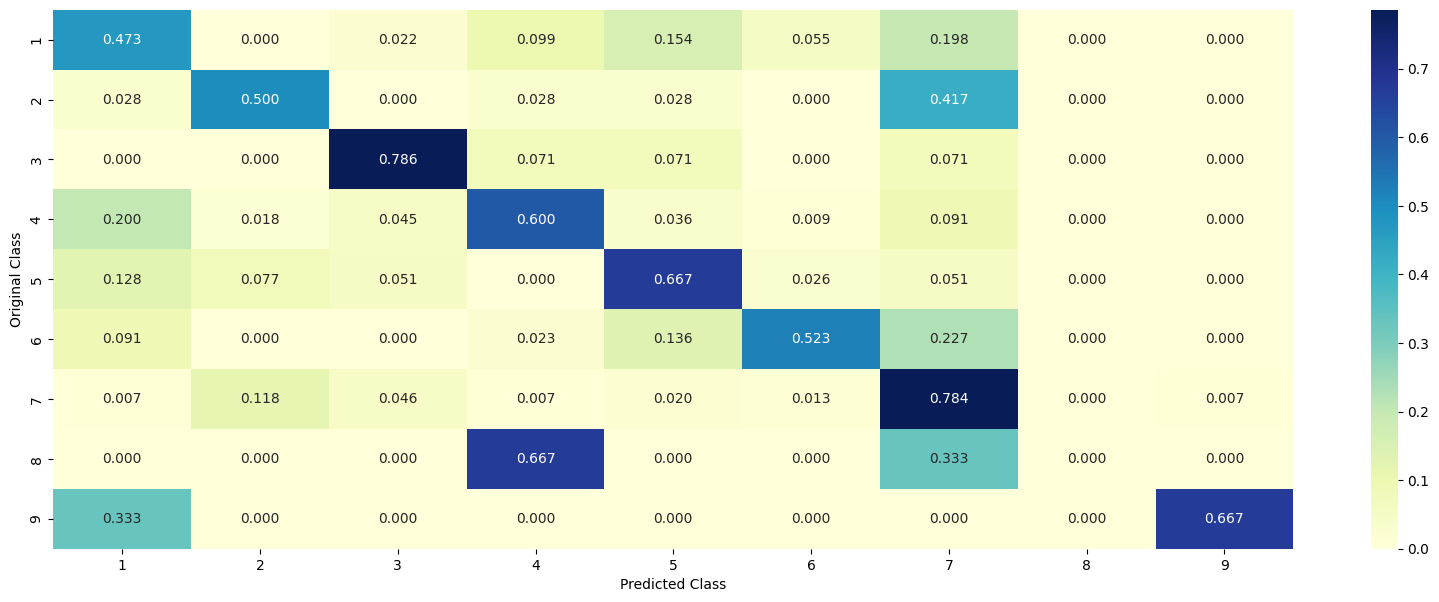

In [49]:
#Testing the model with best hyper paramters
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [50]:
#Feature Importance, Correctly classified point
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0897 0.0804 0.015  0.1114 0.0434 0.0355 0.6149 0.0058 0.0039]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [51]:
test_df['TEXT'].iloc[test_point_index]

'genes encoding components pi3k akt mtor signaling axis frequently mutated cancer mutations characterized mtor gene mtor kinase using publicly available tumor genome sequencing data generated comprehensive catalog mtor pathway mutations cancer identifying 33 mtor mutations confer pathway hyperactivation mutations cluster six distinct regions c terminal half mtor occur multiple cancer types one cluster particularly prominent kidney cancer activating mutations affect mtor complex assembly subset reduces binding mtor inhibitor deptor mtorc1 signaling cells expressing various activating mutations remains sensitive pharmacological mtor inhibition partially resistant nutrient deprivation lastly cancer cell lines hyperactivating mtor mutations display heightened sensitivity rapamycin culture vivo xenografts suggesting mutations confer mtor pathway dependency keywords personalized mtor mutations biomarker deptor go introduction mammals pi3k akt mtor pathway regulates cell size mrna translation

In [52]:
test_df['Gene'].iloc[test_point_index]

'RHEB'

In [53]:
no_feature

100

In [54]:
clf.feature_log_prob_.shape

(9, 54734)

In [55]:
indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
indices[0]

array([   44, 20513, 20527, 34149, 23096,    38,    39,    43, 16650,
          59,    61,    65,    66,    67,    69,    26,    24,    45,
          46,    47,    48,    49, 29959, 54708, 54710,    33,    35,
          18,    19,    20,    21, 54718,    76, 43485, 43486, 50780,
       43493, 43497, 43504,    77,    78,    79,    80,    81,    87,
          88,    89,    90,    91,    94,    95,    96,    97,    99,
         100,   101,   105,   106,   107,   109,   111,   112,   113,
         114,   115,   116,   118,   121,   122,   125,   127,   129,
       47079, 29942, 29946, 29947, 29948, 29949, 29950, 29951, 29952,
       50781, 29954, 29955, 29957, 50785,   131,   132,   134,   137,
         138,   139, 54685, 54686, 50788, 54691, 54692, 54693, 43523,
       43529])

In [56]:
#Feature Importance, Incorrectly classified point
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2864 0.0792 0.0146 0.4349 0.0426 0.0343 0.0984 0.0059 0.0038]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


#### 2. K-Nearest Neighbour Classification

In [57]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


for alpha = 5
Log Loss : 1.3181527166536917
for alpha = 11
Log Loss : 1.3222446442766698
for alpha = 15
Log Loss : 1.3697743079414653
for alpha = 21
Log Loss : 1.4468374718798387
for alpha = 31
Log Loss : 1.4962318086659465
for alpha = 41
Log Loss : 1.5079921337108948
for alpha = 51
Log Loss : 1.5182350453763065
for alpha = 99
Log Loss : 1.4656743318507746
For values of best alpha =  5 The train log loss is: 0.9881143661997673
For values of best alpha =  5 The cross validation log loss is: 1.3181527166536917
For values of best alpha =  5 The test log loss is: 1.3433313234602162


Log loss : 1.3181527166536917
Number of mis-classified points : 0.44360902255639095
-------------------- Confusion matrix --------------------


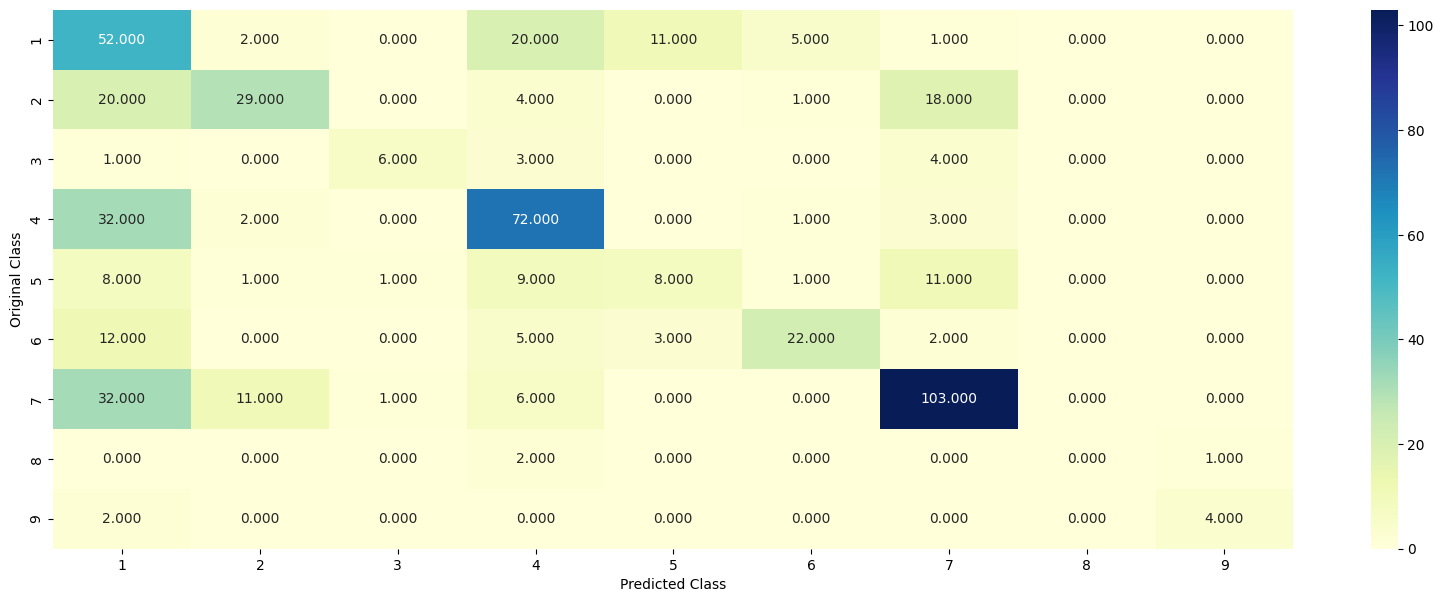

-------------------- Precision matrix (Columm Sum=1) --------------------


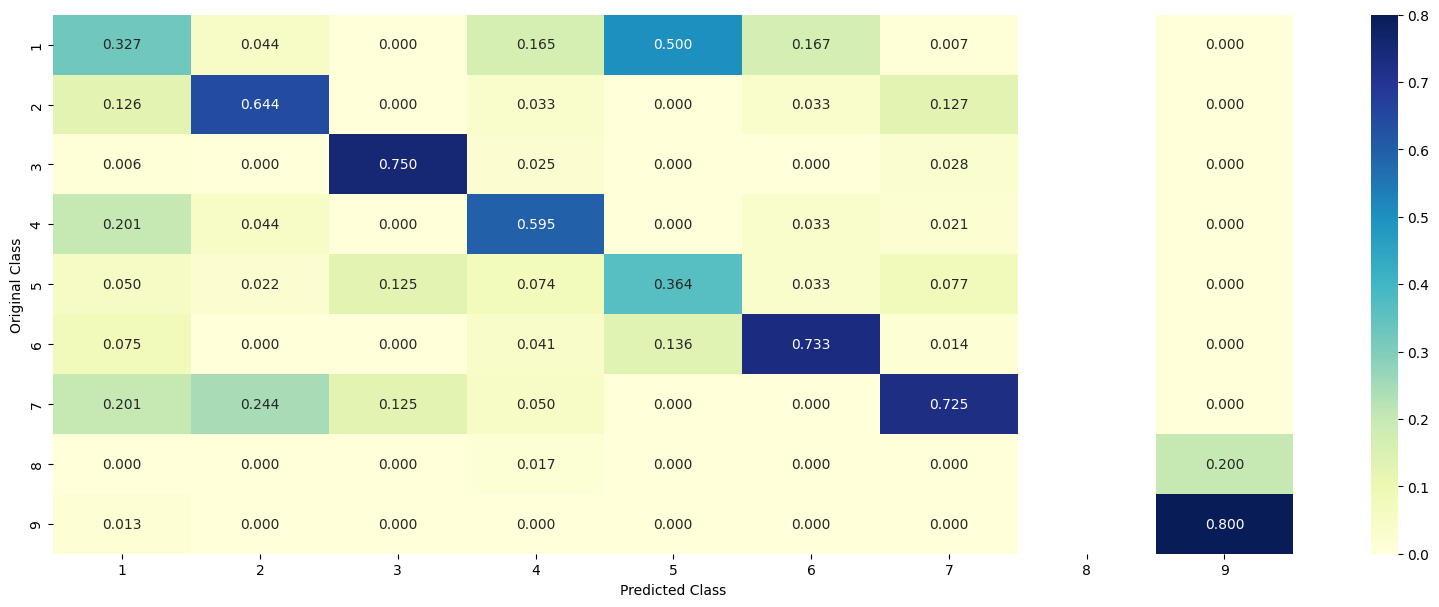

-------------------- Recall matrix (Row sum=1) --------------------


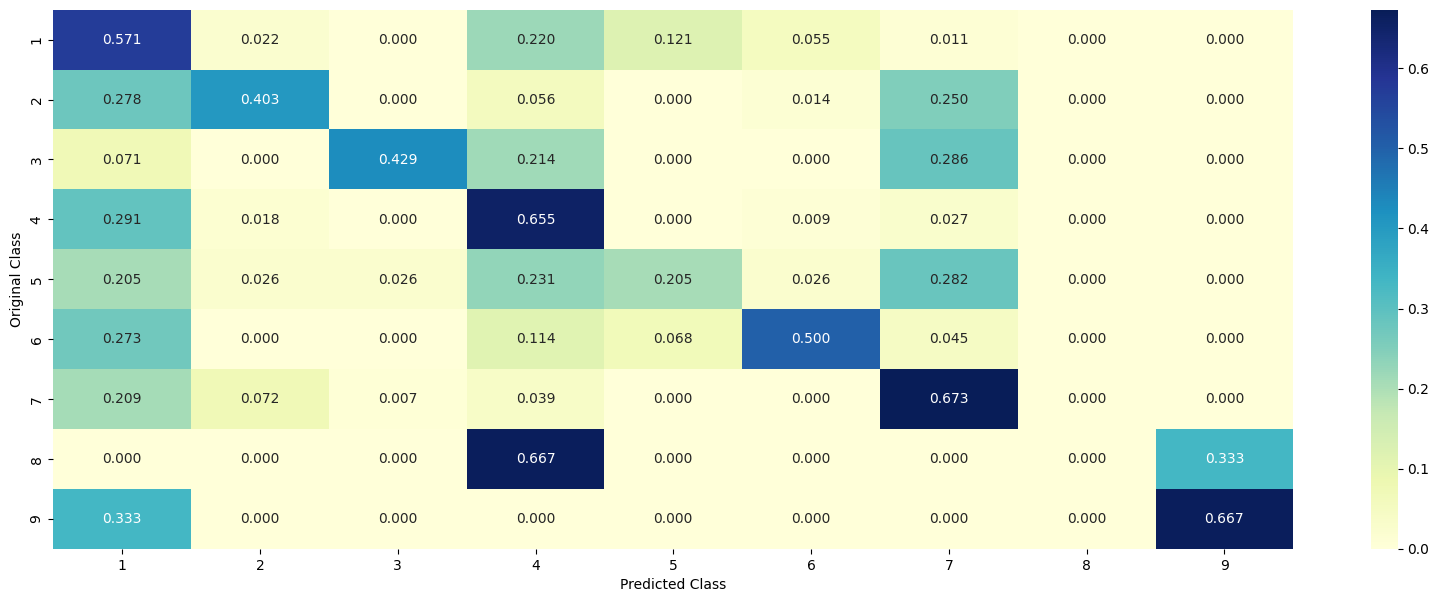

In [58]:
#Testing the model with best hyper paramters
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [59]:
#sample query point
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 7 3 7 7]
Fequency of nearest points : Counter({np.int64(7): 4, np.int64(3): 1})


#### 3. Logistic Regression

##### 3.1. Class balancing (though we have imbalanced classes)

In [60]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42) #balanced
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for alpha = 1e-06
Log Loss : 1.2856931751646496
for alpha = 1e-05
Log Loss : 1.2195080981799242
for alpha = 0.0001
Log Loss : 1.0546560993655576
for alpha = 0.001
Log Loss : 1.066345971885655
for alpha = 0.01
Log Loss : 1.188371336170892
for alpha = 0.1
Log Loss : 1.3050774418532287
for alpha = 1
Log Loss : 1.5263918140790225
for alpha = 10
Log Loss : 1.562647023670582
for alpha = 100
Log Loss : 1.5666927477338215
For values of best alpha =  0.0001 The train log loss is: 0.5083492800765083
For values of best alpha =  0.0001 The cross validation log loss is: 1.0546560993655576
For values of best alpha =  0.0001 The test log loss is: 1.091348021295593


Log loss : 1.0546560993655576
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


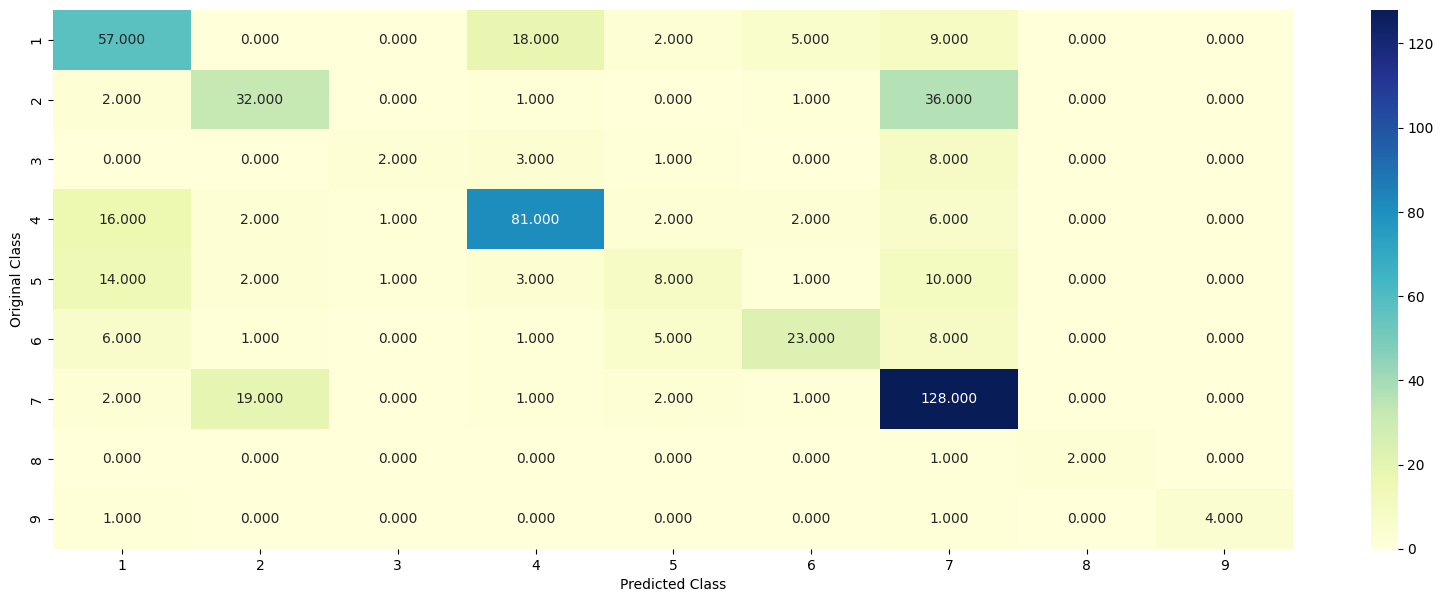

-------------------- Precision matrix (Columm Sum=1) --------------------


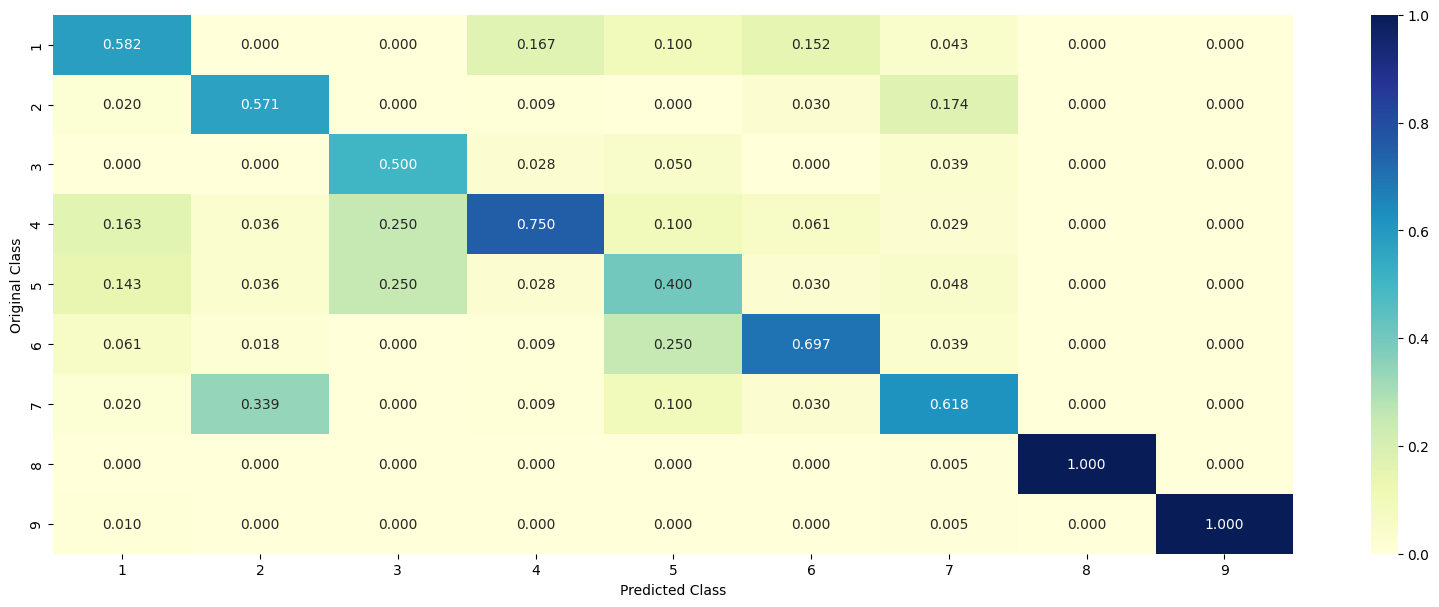

-------------------- Recall matrix (Row sum=1) --------------------


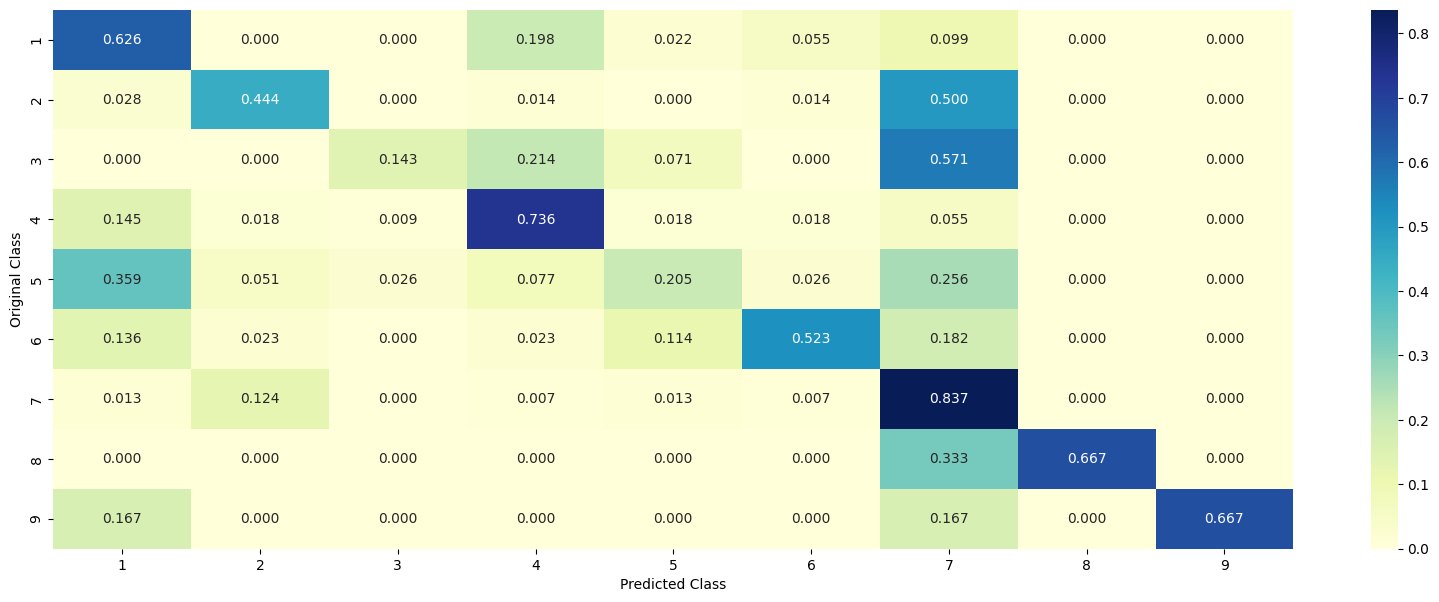

In [61]:
#Testing the model with best hyper paramters
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [62]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [63]:
# Correctly Classified point
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0012 0.0241 0.0405 0.0055 0.0044 0.002  0.9147 0.0041 0.0035]]
Actual Class : 7
--------------------------------------------------
251 Text feature [q61e] present in test data point [True]
261 Text feature [activated] present in test data point [True]
269 Text feature [constitutively] present in test data point [True]
300 Text feature [activation] present in test data point [True]
319 Text feature [elicited] present in test data point [True]
325 Text feature [loss] present in test data point [True]
344 Text feature [downstream] present in test data point [True]
375 Text feature [serum] present in test data point [True]
410 Text feature [dramatic] present in test data point [True]
478 Text feature [activate] present in test data point [True]
481 Text feature [phosphorylation] present in test data point [True]
Out of the top  500  features  11 are present in query point


In [64]:
# Incorrectly Classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1559 0.0773 0.0256 0.4594 0.0531 0.0254 0.1844 0.0069 0.012 ]]
Actual Class : 4
--------------------------------------------------
473 Text feature [instability] present in test data point [True]
Out of the top  500  features  1 are present in query point


##### 3.2. Classes without balancing

In [65]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for alpha = 1e-06
Log Loss : 1.282853005524754
for alpha = 1e-05
Log Loss : 1.2275932210781106
for alpha = 0.0001
Log Loss : 1.0609879320283524
for alpha = 0.001
Log Loss : 1.0709306312209161
for alpha = 0.01
Log Loss : 1.2033611752659312
for alpha = 0.1
Log Loss : 1.4354349917866434
for alpha = 1
Log Loss : 1.6234883262460493
For values of best alpha =  0.0001 The train log loss is: 0.5012485003734526
For values of best alpha =  0.0001 The cross validation log loss is: 1.0609879320283524
For values of best alpha =  0.0001 The test log loss is: 1.0981504129810917


Log loss : 1.0609879320283524
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


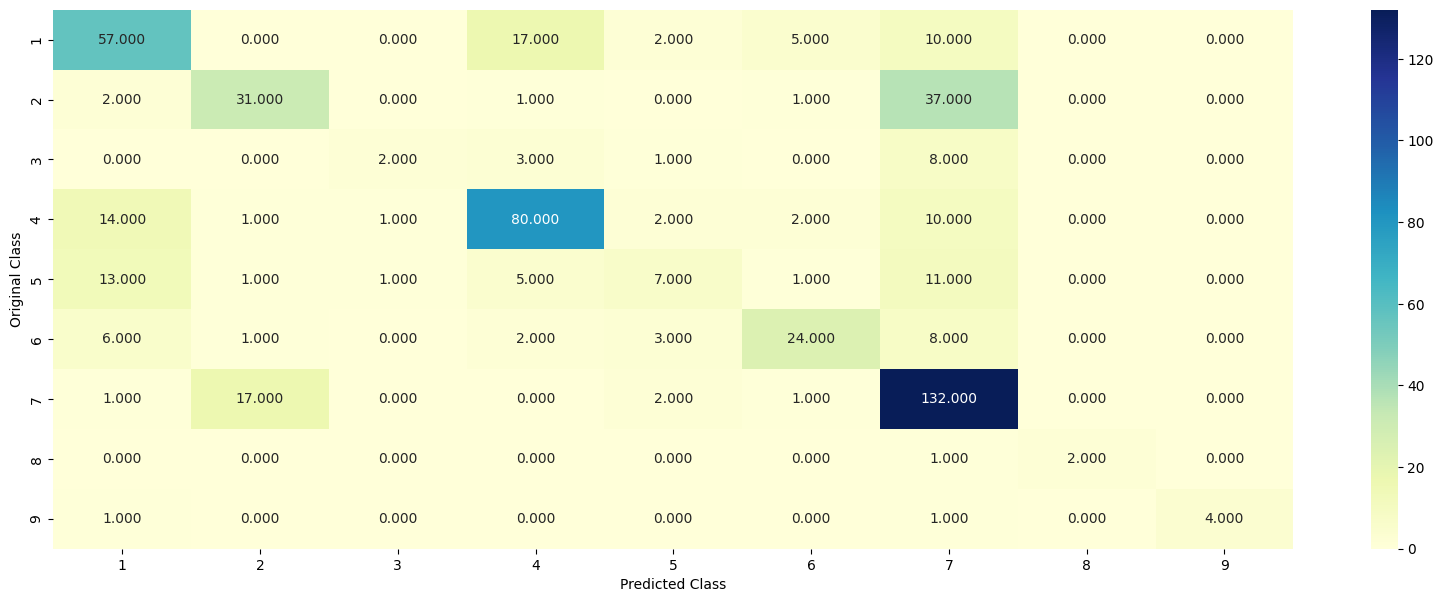

-------------------- Precision matrix (Columm Sum=1) --------------------


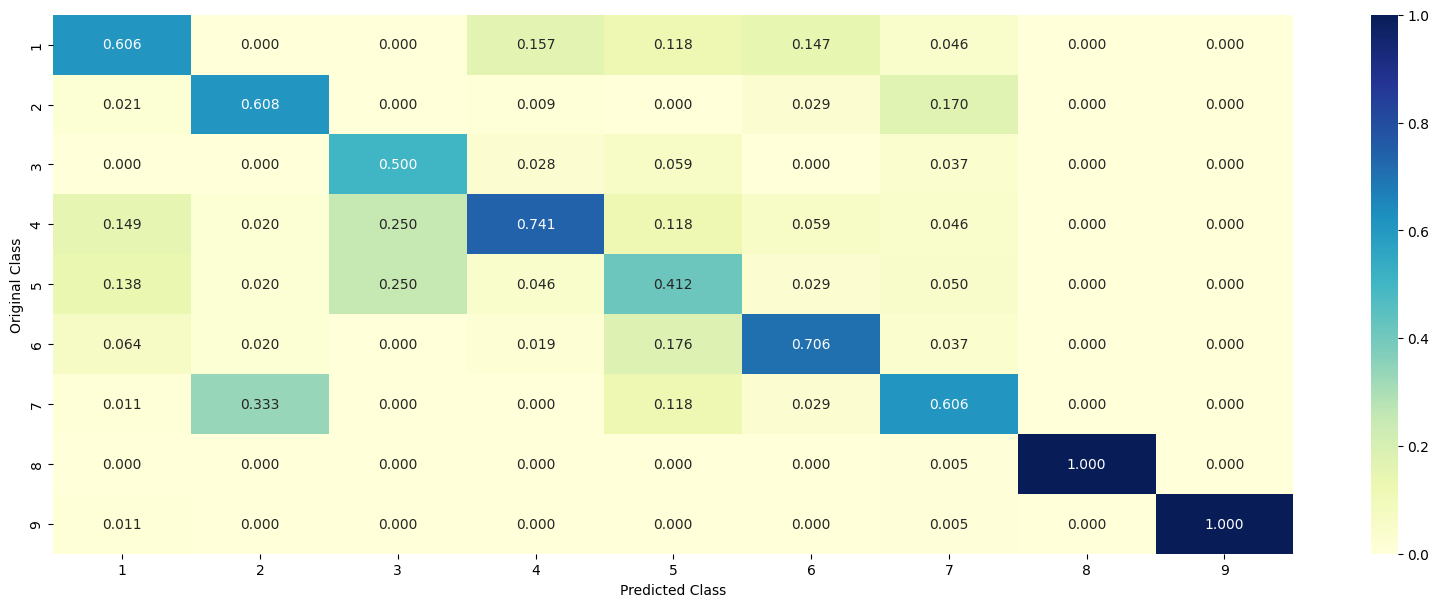

-------------------- Recall matrix (Row sum=1) --------------------


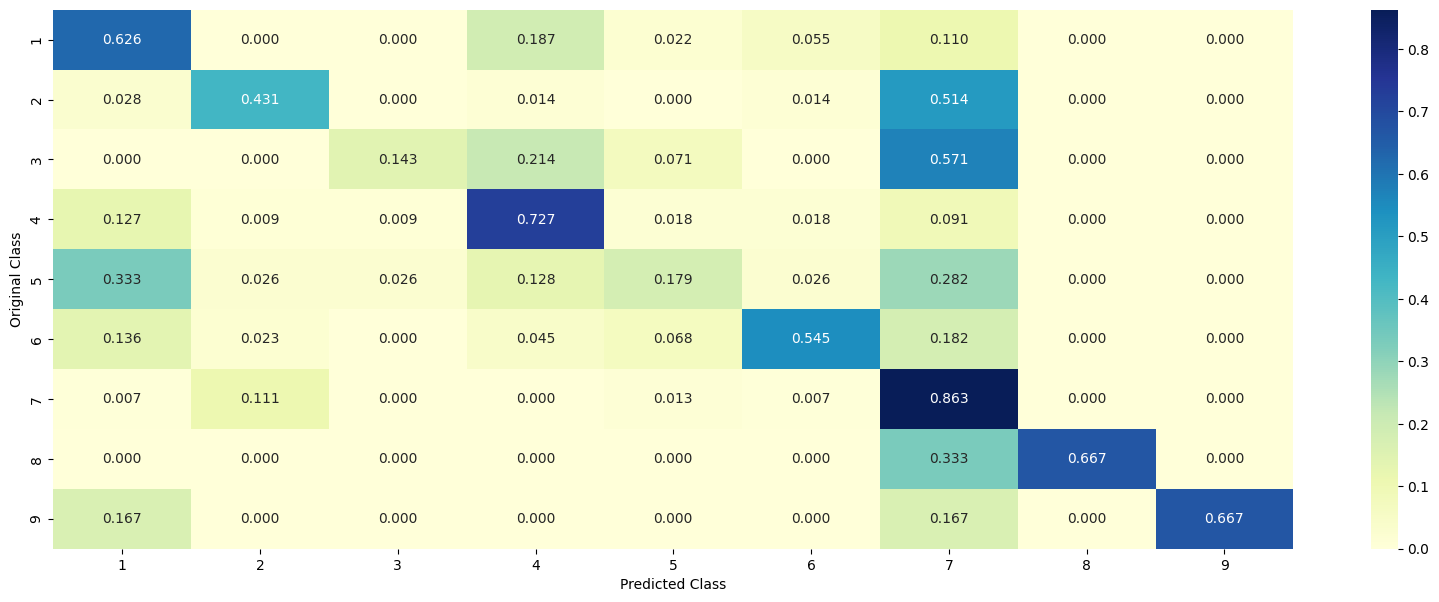

In [66]:
#Testing the model with best hyper paramters
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [67]:
# Correctly Classified point
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.40e-03 2.76e-02 3.11e-02 8.00e-03 3.50e-03 1.50e-03 9.23e-01 3.50e-03
  4.00e-04]]
Actual Class : 7
--------------------------------------------------
312 Text feature [constitutively] present in test data point [True]
318 Text feature [activated] present in test data point [True]
331 Text feature [q61e] present in test data point [True]
356 Text feature [activation] present in test data point [True]
422 Text feature [downstream] present in test data point [True]
426 Text feature [loss] present in test data point [True]
442 Text feature [fkbp12] present in test data point [True]
495 Text feature [dramatic] present in test data point [True]
Out of the top  500  features  8 are present in query point


In [68]:
# Incorrectly Classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1518 0.0756 0.0115 0.4716 0.0478 0.0223 0.2079 0.0074 0.004 ]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


#### 4. Linear SVM

In [69]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for C = 1e-05
Log Loss : 1.279007990697802
for C = 0.0001
Log Loss : 1.1924548645884887
for C = 0.001
Log Loss : 1.0838608282478357
for C = 0.01
Log Loss : 1.1597180063319528
for C = 0.1
Log Loss : 1.3155245839453136
for C = 1
Log Loss : 1.5674988466685889
for C = 10
Log Loss : 1.5674522271761118
for C = 100
Log Loss : 1.5674521592193325
For values of best alpha =  0.001 The train log loss is: 0.5788384783667403
For values of best alpha =  0.001 The cross validation log loss is: 1.0838608282478357
For values of best alpha =  0.001 The test log loss is: 1.140189336789541


Log loss : 1.0838608282478357
Number of mis-classified points : 0.3890977443609023
-------------------- Confusion matrix --------------------


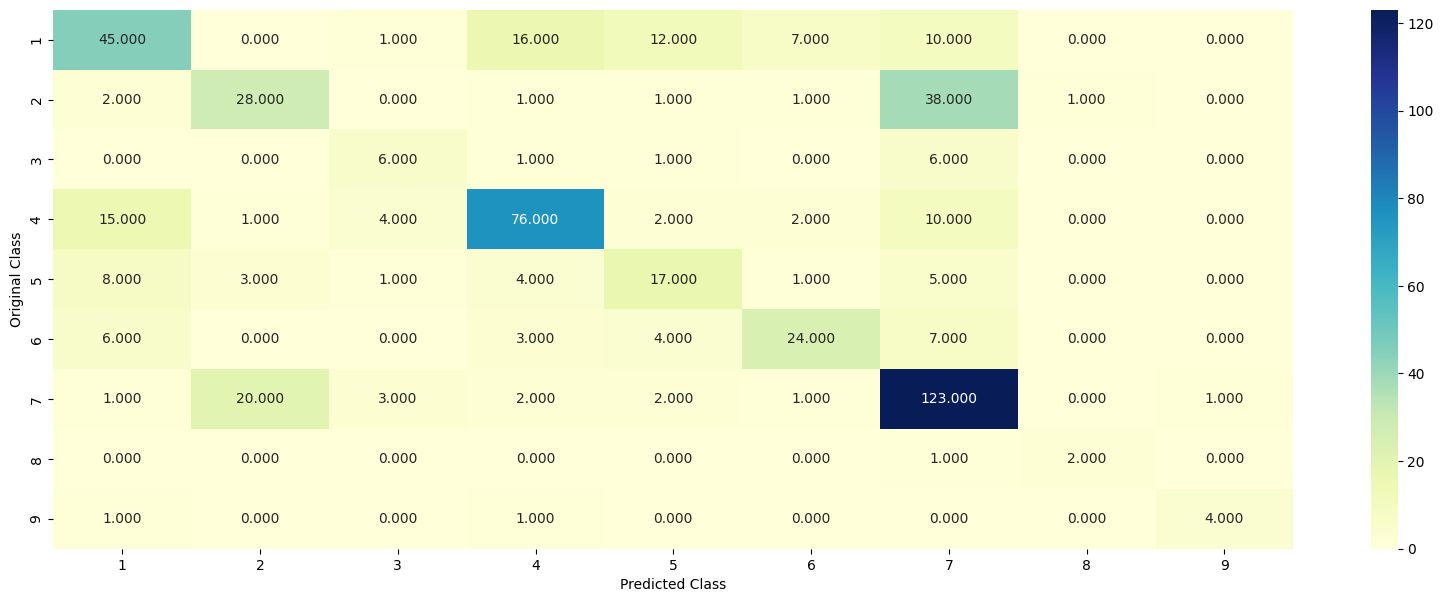

-------------------- Precision matrix (Columm Sum=1) --------------------


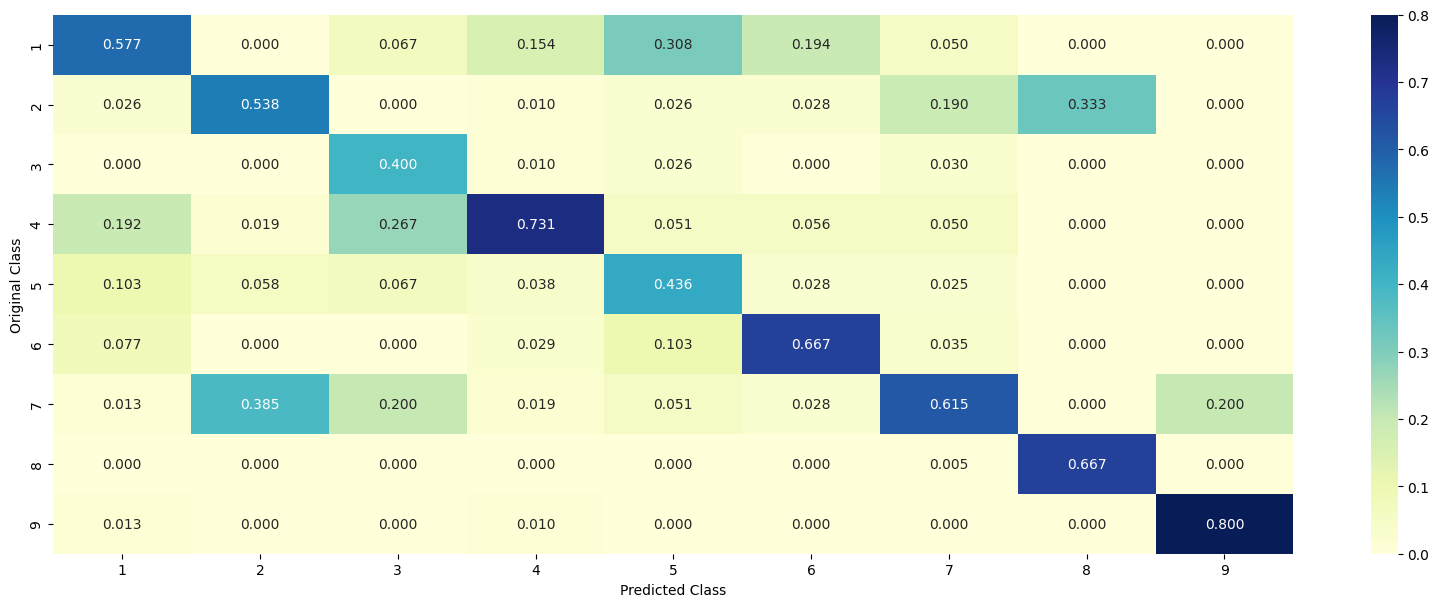

-------------------- Recall matrix (Row sum=1) --------------------


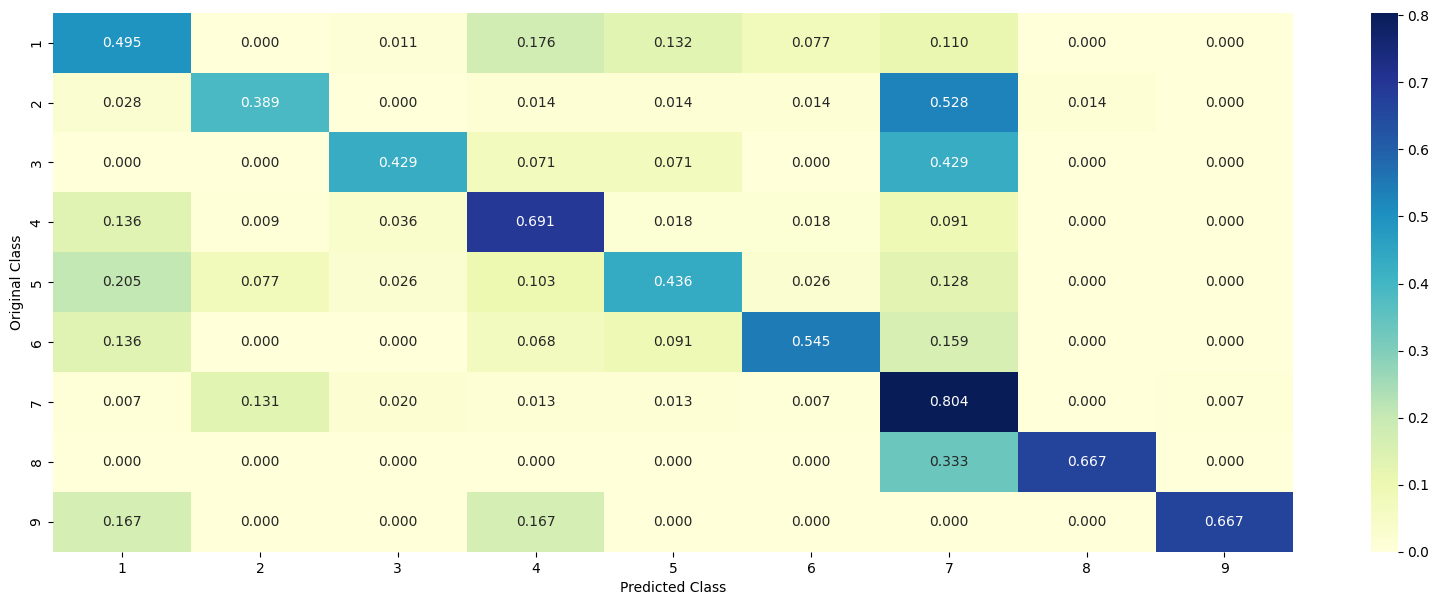

In [70]:
#Testing model with best hyper parameters
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [71]:
#For Correctly classified point
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0062 0.0241 0.09   0.0424 0.0133 0.0182 0.7979 0.0042 0.0036]]
Actual Class : 7
--------------------------------------------------
218 Text feature [q61e] present in test data point [True]
289 Text feature [constitutively] present in test data point [True]
327 Text feature [activated] present in test data point [True]
339 Text feature [activation] present in test data point [True]
362 Text feature [elicited] present in test data point [True]
409 Text feature [activate] present in test data point [True]
441 Text feature [transformation] present in test data point [True]
464 Text feature [phosphorylation] present in test data point [True]
487 Text feature [expressing] present in test data point [True]
495 Text feature [downstream] present in test data point [True]
Out of the top  500  features  10 are present in query point


In [72]:
#For Incorrectly classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1461 0.0673 0.0187 0.4126 0.0617 0.0261 0.2547 0.0052 0.0077]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


#### 5.1. Random Forest Classifier (With TfidVectorizer)

In [73]:
alpha = [50,100,200,500]
max_depth = [3,5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y))

for n_estimators = 50 and max depth =  3
Log Loss : 1.3193429459681207
for n_estimators = 50 and max depth =  5
Log Loss : 1.2573890377361507
for n_estimators = 50 and max depth =  10
Log Loss : 1.18384113720093
for n_estimators = 100 and max depth =  3
Log Loss : 1.31157269120495
for n_estimators = 100 and max depth =  5
Log Loss : 1.2364593340002865
for n_estimators = 100 and max depth =  10
Log Loss : 1.162396421741866
for n_estimators = 200 and max depth =  3
Log Loss : 1.2952517092734908
for n_estimators = 200 and max depth =  5
Log Loss : 1.2302553602777044
for n_estimators = 200 and max depth =  10
Log Loss : 1.1538074876573687
for n_estimators = 500 and max depth =  3
Log Loss : 1.2846135861318573
for n_estimators = 500 and max depth =  5
Log Loss : 1.217232700974284
for n_estimators = 500 and max depth =  10
Log Loss : 1.151116380823965
For values of best estimator =  200 The train log loss is: 0.6395669586246588
For values of best estimator =  200 The cross validation log los

Log loss : 1.1538074876573687
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


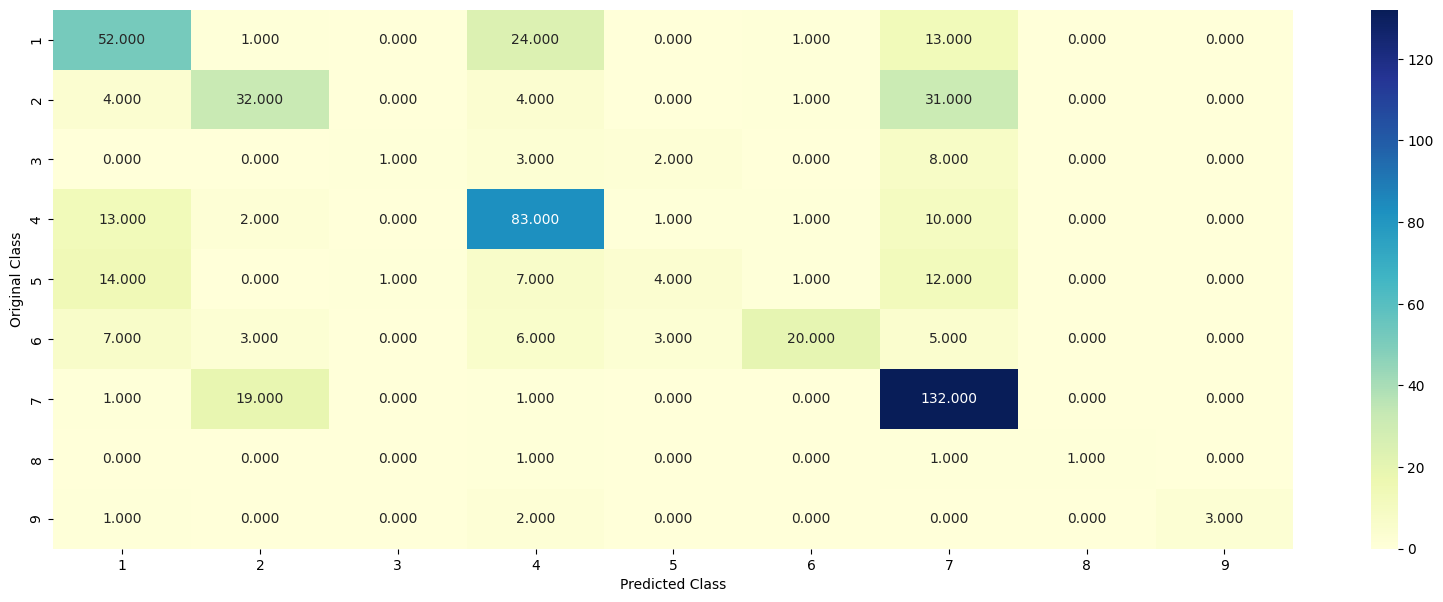

-------------------- Precision matrix (Columm Sum=1) --------------------


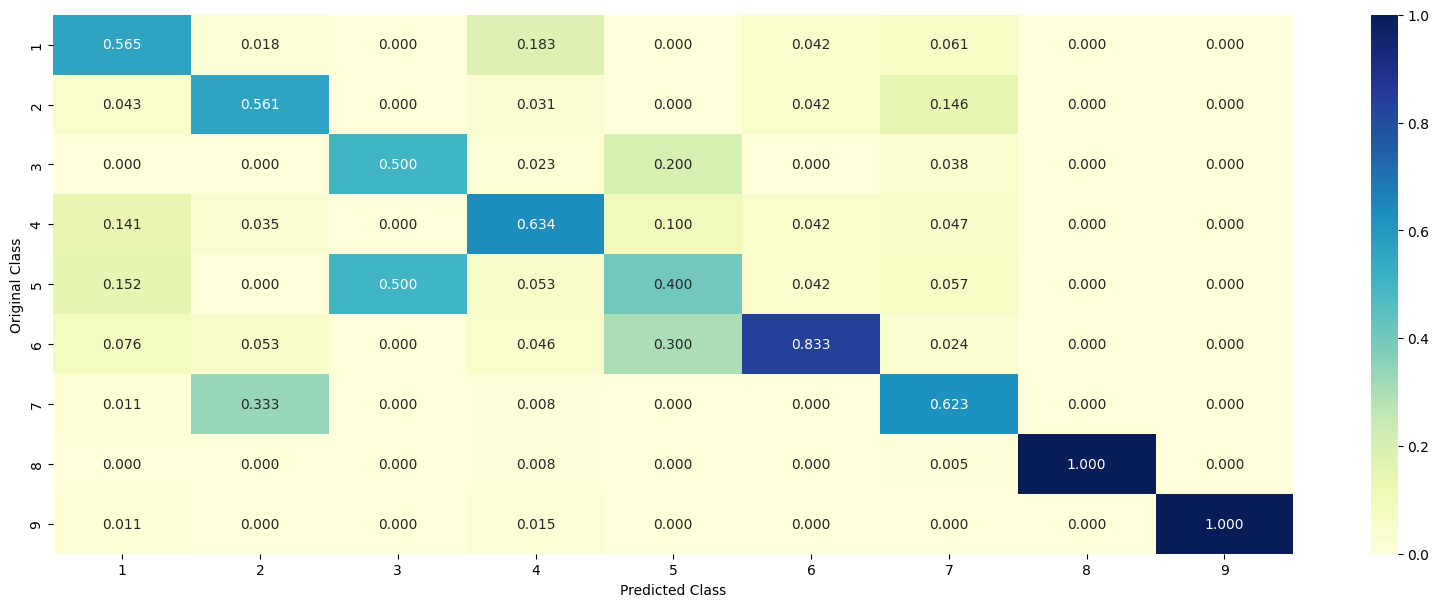

-------------------- Recall matrix (Row sum=1) --------------------


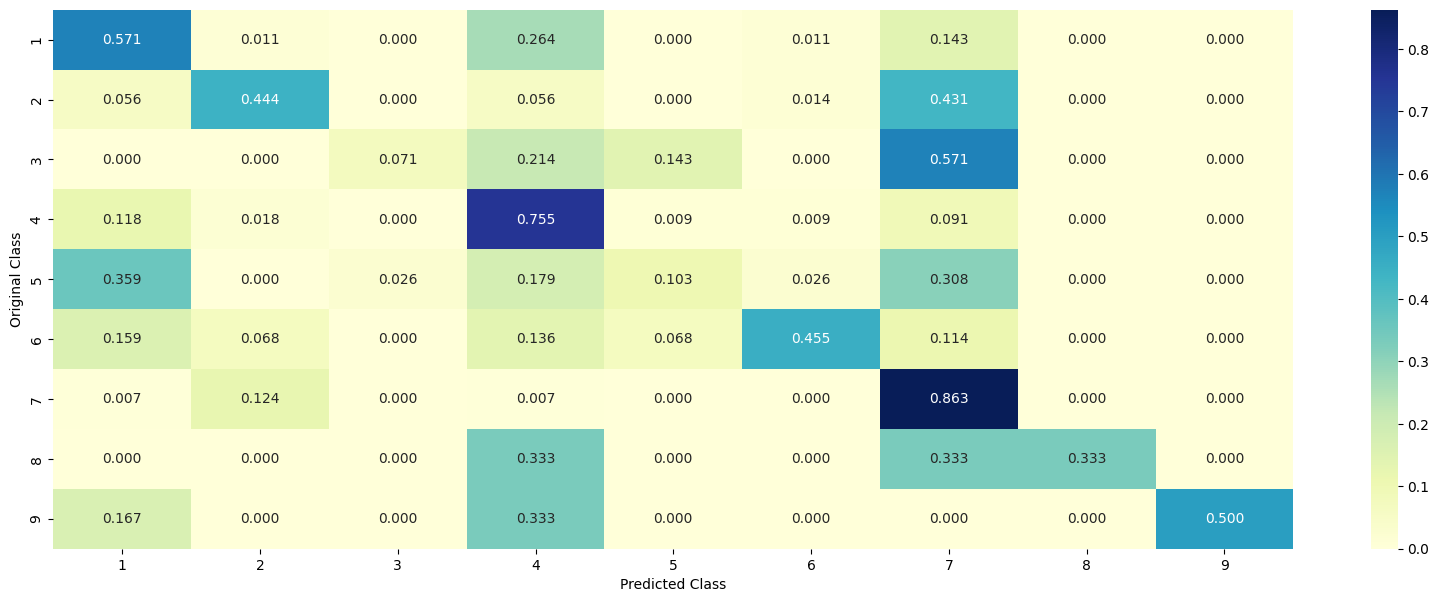

In [74]:
#Testing model with best hyper parameters 
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,y_cv, clf)

#### 5.2. Random Forest Classifier (With Response coding)

In [76]:
alpha = [50,100,200,500]
max_depth = [3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y))

for n_estimators = 50 and max depth =  3
Log Loss : 1.398329239705991
for n_estimators = 50 and max depth =  5
Log Loss : 1.3009005204972428
for n_estimators = 50 and max depth =  10
Log Loss : 1.670736909763379
for n_estimators = 100 and max depth =  3
Log Loss : 1.446079709742024
for n_estimators = 100 and max depth =  5
Log Loss : 1.2966056081414579
for n_estimators = 100 and max depth =  10
Log Loss : 1.6937356925645208
for n_estimators = 200 and max depth =  3
Log Loss : 1.444111950853431
for n_estimators = 200 and max depth =  5
Log Loss : 1.3470105335270421
for n_estimators = 200 and max depth =  10
Log Loss : 1.7014588655581173
for n_estimators = 500 and max depth =  3
Log Loss : 1.4989408948495022
for n_estimators = 500 and max depth =  5
Log Loss : 1.3568547212742508
for n_estimators = 500 and max depth =  10
Log Loss : 1.6980274574709429
For values of best alpha =  100 The train log loss is: 0.1401591322193741
For values of best alpha =  100 The cross validation log loss is:

Log loss : 1.446079709742024
Number of mis-classified points : 0.5601503759398496
-------------------- Confusion matrix --------------------


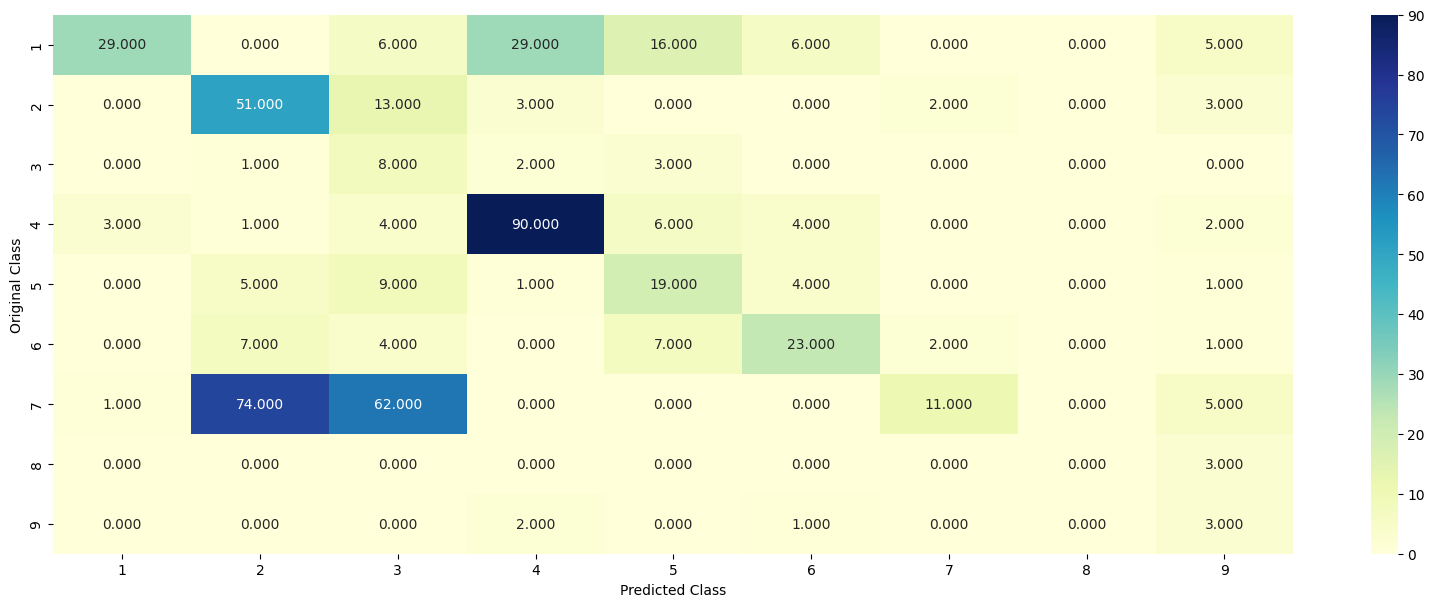

-------------------- Precision matrix (Columm Sum=1) --------------------


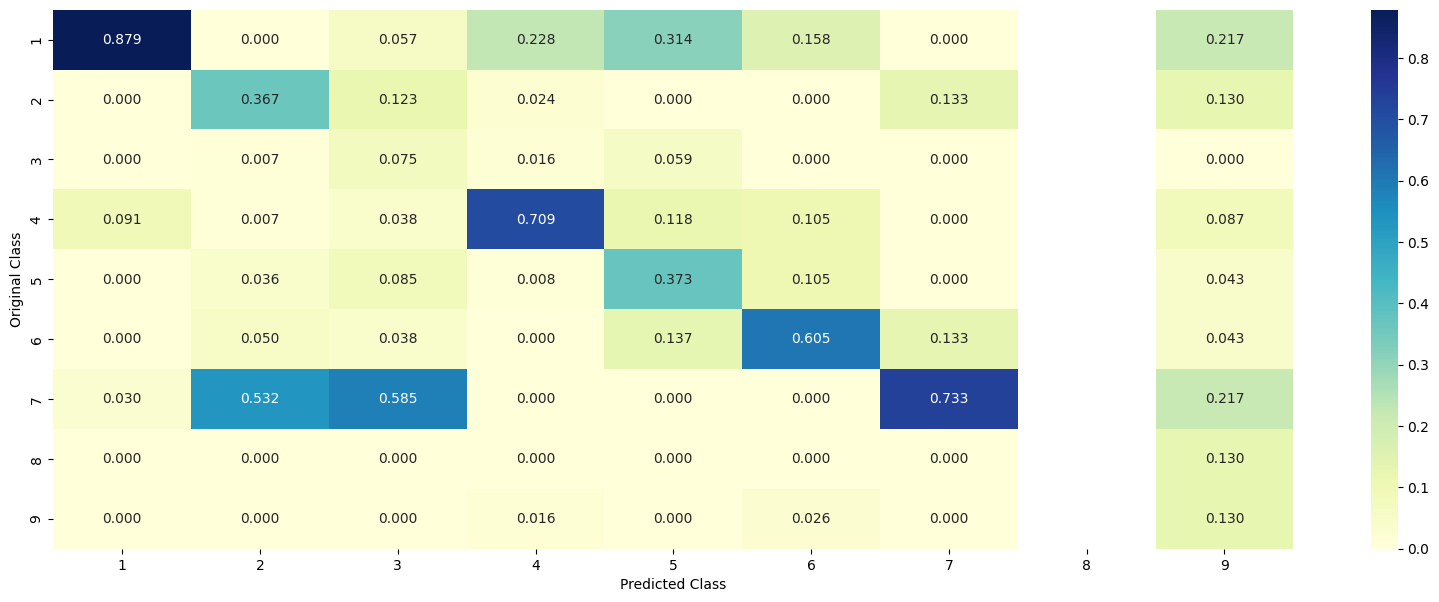

-------------------- Recall matrix (Row sum=1) --------------------


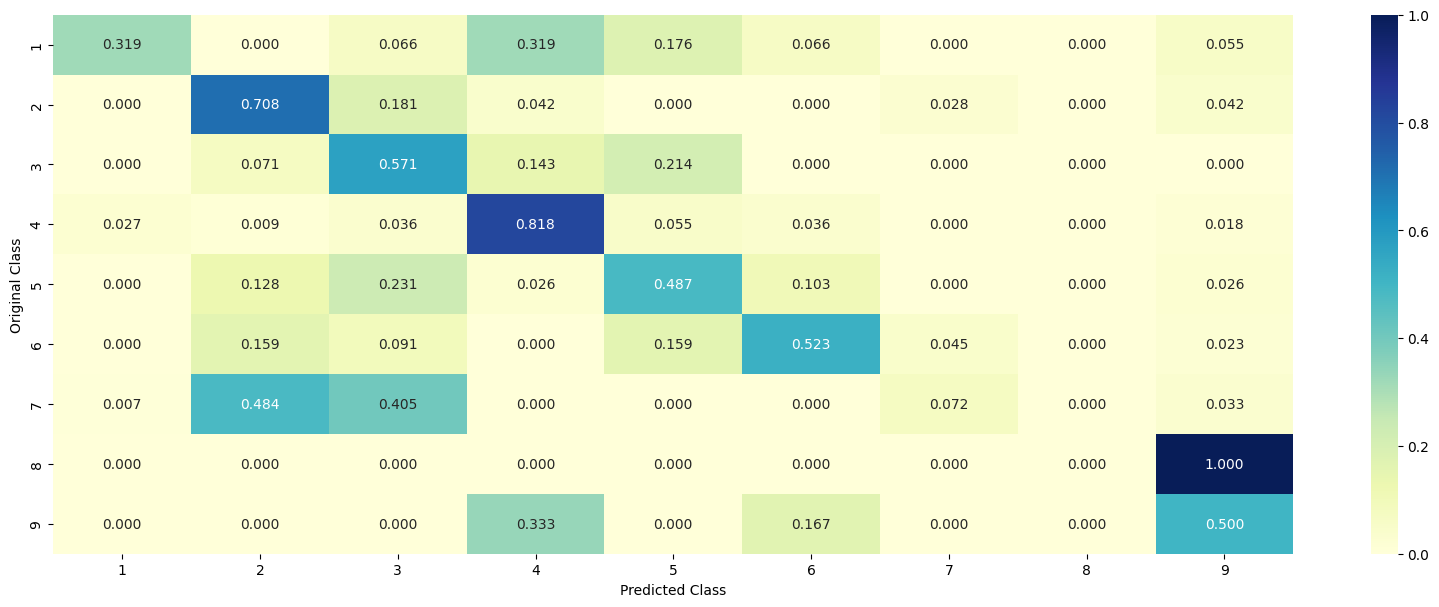

In [77]:
#Testing model with best hyper parameters
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [78]:
# Correctly Classified point
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0102 0.2063 0.3949 0.0054 0.0285 0.0218 0.2971 0.018  0.0177]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [79]:
# Incorrectly Classified point
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1002 0.0054 0.0553 0.5263 0.1168 0.1441 0.0022 0.0189 0.0309]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


### Stacking Classifier

In [80]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=1e-5)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

clf4 = KNeighborsClassifier(n_neighbors=5)
clf4.fit(train_x_onehotCoding,train_y)
sig_clf4 = CalibratedClassifierCV(clf4, method="sigmoid")

clf5 = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf5.fit(train_x_onehotCoding,train_y)
sig_clf5 = CalibratedClassifierCV(clf5, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
sig_clf4.fit(train_x_onehotCoding, train_y)
print("K Nearest Neighbour : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_onehotCoding))))
sig_clf5.fit(train_x_onehotCoding, train_y)
print("Random Forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf5.predict_proba(cv_x_onehotCoding))))

Logistic Regression :  Log Loss: 1.07
Support vector machines : Log Loss: 1.09
Naive Bayes : Log Loss: 1.25
K Nearest Neighbour : Log Loss: 1.32
Random Forest : Log Loss: 1.15


In [81]:
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf5',clf5)], final_estimator=lr)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.751
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.390
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.095
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.070
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.088
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.111


In [82]:
print("-"*50)
alpha = [0.00001,0.0001,0.001,0.01,0.1,1.0] 
best_alpha = 999
for i in alpha:
    lr1 = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
    sclf1 = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf3',clf3)], final_estimator=lr1)
    sclf1.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf1.predict_proba(cv_x_onehotCoding))))
    log_error1 =log_loss(cv_y, sclf1.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error1:
        best_alpha = log_error1

--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000010 Log Loss: 8.341
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.925
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.071
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.089
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.259
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.826


Log loss (train) on the stacking classifier : 0.442602516589715
Log loss (CV) on the stacking classifier : 1.0702539420925055
Log loss (test) on the stacking classifier : 1.0818185765001336
Number of missclassified point : 0.35639097744360904
-------------------- Confusion matrix --------------------


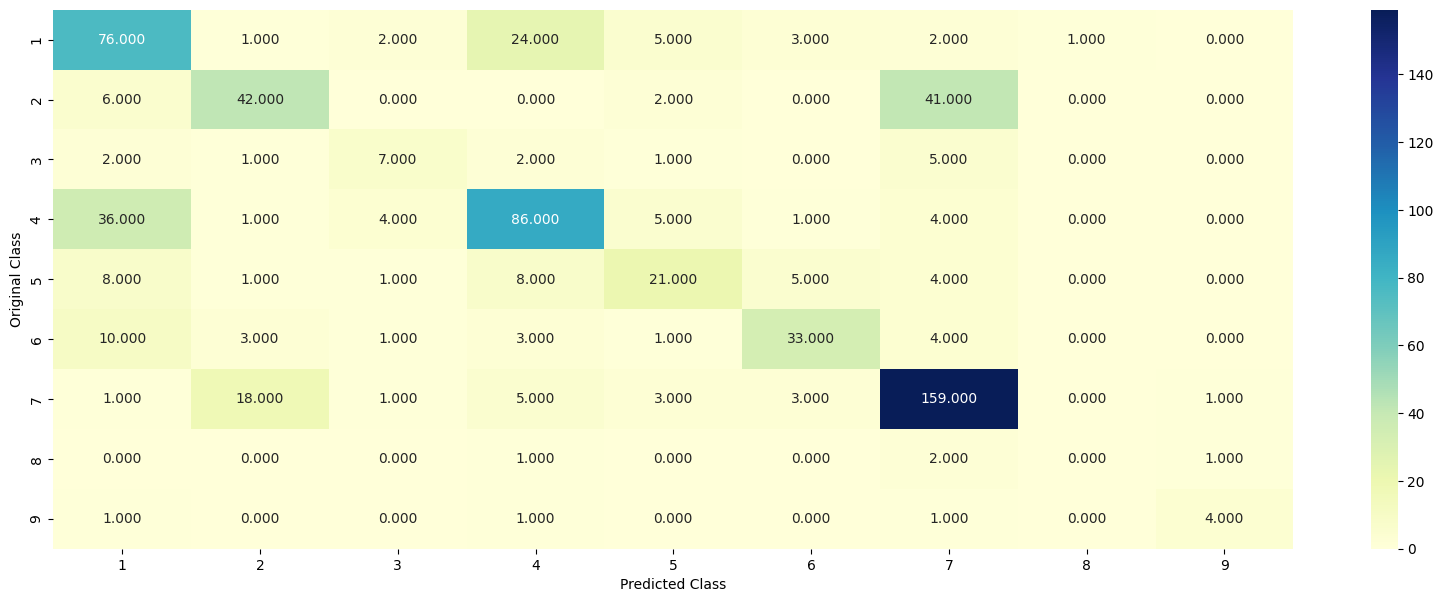

-------------------- Precision matrix (Columm Sum=1) --------------------


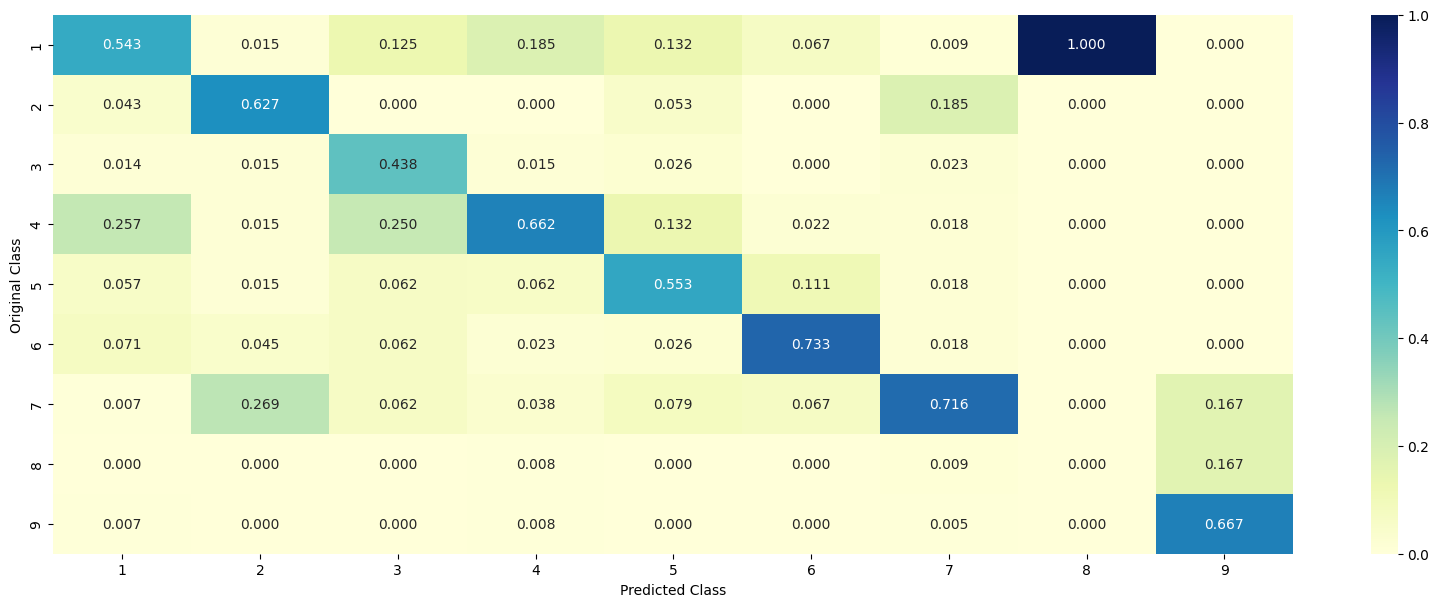

-------------------- Recall matrix (Row sum=1) --------------------


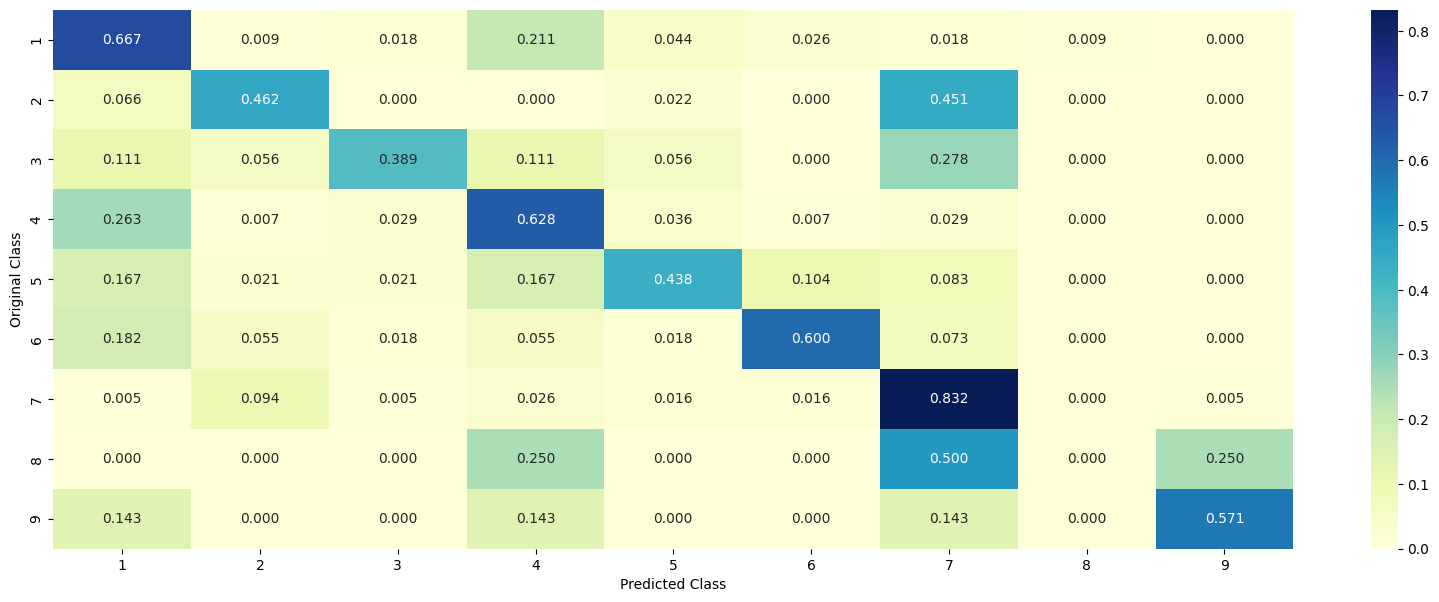

In [83]:
# testing the model with the best hyper parameters
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf5',clf5)], final_estimator=lr)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [84]:
num_classes = 10

model = Sequential([
    Dense(512, activation='relu', input_shape=(train_x_onehotCoding.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [86]:
model.fit(train_x_onehotCoding, y_train, epochs=12, batch_size=48,
          validation_data=(cv_x_onehotCoding, y_cv))

Epoch 1/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.8005 - loss: 0.5875 - val_accuracy: 0.6447 - val_loss: 1.5540
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.8557 - loss: 0.3927 - val_accuracy: 0.6184 - val_loss: 1.6192
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.8544 - loss: 0.3722 - val_accuracy: 0.6353 - val_loss: 1.7700
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.8763 - loss: 0.3141 - val_accuracy: 0.6071 - val_loss: 1.7013
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.8532 - loss: 0.3507 - val_accuracy: 0.6184 - val_loss: 1.7146
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.8771 - loss: 0.2908 - val_accuracy: 0.6353 - val_loss: 1.8766
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.8813 - loss: 0.2885 - val_accuracy: 0.6466 - val_loss: 1.8841
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.8904 - loss: 0.2598 - val_accu

In [87]:
#preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('gene', TfidfVectorizer(), 'Gene'),
        ('variation', TfidfVectorizer(), 'Variation'),
        ('text', TfidfVectorizer(max_features=10000), 'TEXT')
    ]
)

In [88]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', sclf)
])

pipeline.fit(train_df, y_train)
y_pred = pipeline.predict(cv_df)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.58      0.61        91
           2       0.60      0.40      0.48        72
           3       0.00      0.00      0.00        14
           4       0.68      0.85      0.76       110
           5       0.53      0.26      0.34        39
           6       0.76      0.50      0.60        44
           7       0.66      0.91      0.76       153
           8       1.00      0.33      0.50         3
           9       0.75      0.50      0.60         6

    accuracy                           0.66       532
   macro avg       0.62      0.48      0.52       532
weighted avg       0.64      0.66      0.63       532

